In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-learn tqdm --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

In [ ]:
class DeepFakeNPYDataset(Dataset):
    def __init__(self, metadata_csv, features_dir):
        self.df = pd.read_csv(metadata_csv)
        self.features_dir = Path(features_dir)
        self.df = self.df[self.df["filename"].str.replace(".mp4", ".npy").isin(
            [f.name for f in self.features_dir.glob("*.npy")])].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"].replace(".mp4", ".npy")
        label = 1 if row["label"].upper() == "FAKE" else 0
        features = np.load(self.features_dir / filename)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(x).squeeze(1)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.float().to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            preds = model(X)
            all_preds.extend((preds.cpu() > 0.5).int().numpy())
            all_labels.extend(y.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return acc, f1

In [ ]:
base_path = Path("/content/drive/MyDrive/DeepFake Detection")
features_dir = base_path / "processed_features/strategy_1"
metadata_csv = base_path / "metadata.csv"

full_dataset = DeepFakeNPYDataset(metadata_csv, features_dir)
train_len = int(0.8 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [ ]:
EPOCHS = 100  # 👈 Increase to 100

# ✅ Early stopping setup
best_f1 = 0
patience = 10
patience_counter = 0

# ✅ Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

# ✅ Lists for plotting later
train_losses = []
val_accuracies = []
val_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    # Save values for plotting
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), base_path / "strategy1_C_best_model.pth")
    else:
        patience_counter += 1

    # LR scheduler step
    scheduler.step(val_f1)

    # Early stopping
    if patience_counter >= patience:
        print("⏹️ Early stopping triggered. Training halted.")
        break

print(f"\n✅ Best model saved to strategy1_C_best_model.pth (F1: {best_f1:.4f})")


Epoch 1/100 - Loss: 0.6523 | Val Acc: 0.6344 | F1: 0.6542
Epoch 2/100 - Loss: 0.5990 | Val Acc: 0.6719 | F1: 0.6140
Epoch 3/100 - Loss: 0.5751 | Val Acc: 0.7134 | F1: 0.7106
Epoch 4/100 - Loss: 0.5506 | Val Acc: 0.7292 | F1: 0.7319
Epoch 5/100 - Loss: 0.5252 | Val Acc: 0.7194 | F1: 0.7004
Epoch 6/100 - Loss: 0.5048 | Val Acc: 0.7510 | F1: 0.7605
Epoch 7/100 - Loss: 0.4905 | Val Acc: 0.7609 | F1: 0.7772
Epoch 8/100 - Loss: 0.4638 | Val Acc: 0.7609 | F1: 0.7695
Epoch 9/100 - Loss: 0.4506 | Val Acc: 0.7628 | F1: 0.7665
Epoch 10/100 - Loss: 0.4380 | Val Acc: 0.7668 | F1: 0.7668
Epoch 11/100 - Loss: 0.4262 | Val Acc: 0.7727 | F1: 0.7758
Epoch 12/100 - Loss: 0.4143 | Val Acc: 0.7668 | F1: 0.7748
Epoch 13/100 - Loss: 0.3931 | Val Acc: 0.7767 | F1: 0.7839
Epoch 14/100 - Loss: 0.3897 | Val Acc: 0.7767 | F1: 0.7680
Epoch 15/100 - Loss: 0.3810 | Val Acc: 0.7905 | F1: 0.7837
Epoch 16/100 - Loss: 0.3659 | Val Acc: 0.7885 | F1: 0.8015
Epoch 17/100 - Loss: 0.3533 | Val Acc: 0.7925 | F1: 0.7992
Epoch 

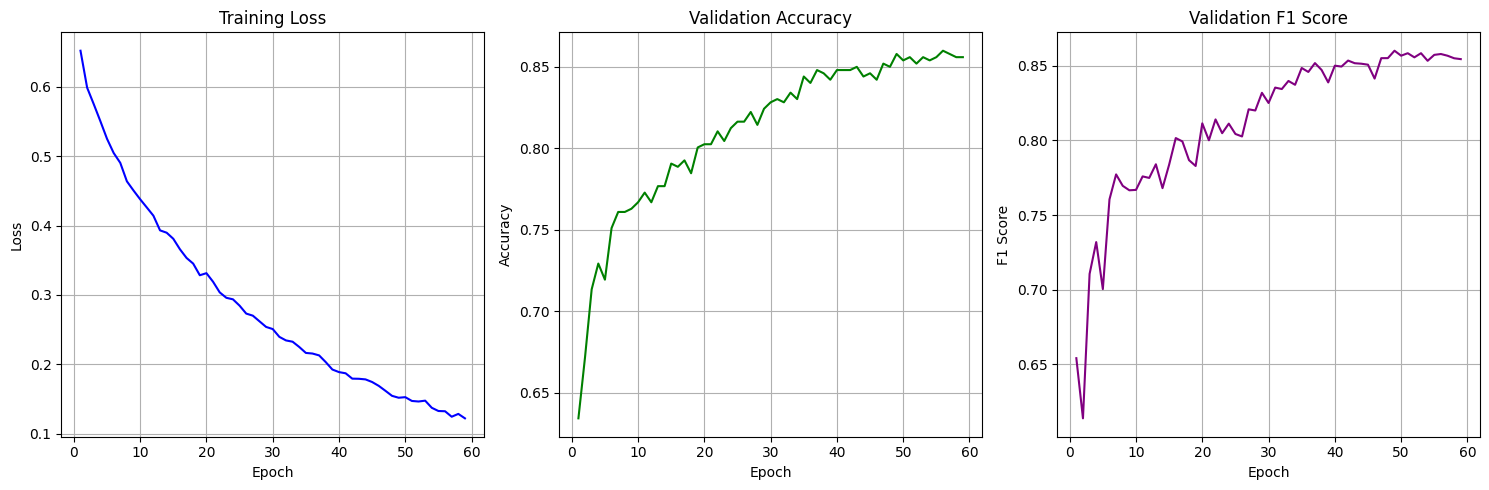

In [ ]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)
x = range(1, epochs_ran + 1)

plt.figure(figsize=(15, 5))

# 🔹 Loss
plt.subplot(1, 3, 1)
plt.plot(x, train_losses, label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# 🔹 Accuracy
plt.subplot(1, 3, 2)
plt.plot(x, val_accuracies, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)

# 🔹 F1 Score
plt.subplot(1, 3, 3)
plt.plot(x, val_f1s, label="Val F1 Score", color="purple")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

        REAL       0.83      0.88      0.86       248
        FAKE       0.88      0.83      0.85       258

    accuracy                           0.86       506
   macro avg       0.86      0.86      0.86       506
weighted avg       0.86      0.86      0.86       506



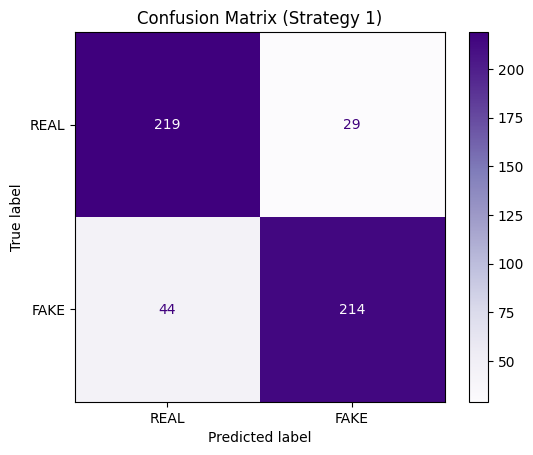

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        preds = model(X.to(device))
        all_preds.extend((preds.cpu() > 0.5).int().numpy())
        all_labels.extend(y.numpy())

# 🧠 Report
print(classification_report(all_labels, all_preds, target_names=["REAL", "FAKE"]))

# 📊 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix (Strategy 1)")
plt.show()


# **Ploting the Graphs**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
import random

# Define base path
base_path = Path("/content/drive/MyDrive/DeepFake Detection")
features_dir = base_path / "processed_features" / "strategy_1"
metadata_path = base_path / "metadata.csv"
model_path = base_path / "strategy1_C_best_model.pth"

# Load metadata
metadata_df = pd.read_csv(metadata_path)
metadata_df["npy_path"] = metadata_df["filename"].apply(lambda f: features_dir / f.replace(".mp4", ".npy"))

# Filter to existing npy files
existing_df = metadata_df[metadata_df["npy_path"].apply(lambda p: p.exists())]

# Take 20 random samples
sample_df = existing_df.sample(n=2500, random_state=42)

# Define your model (1 output neuron)
class MLP(nn.Module):
    def __init__(self, input_dim=2048):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(x)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Predict on 20 samples
results = []
for _, row in sample_df.iterrows():
    npy_path = row["npy_path"]
    label = row["label"]
    filename = row["filename"]

    features = np.load(npy_path)
    input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

    output = model(input_tensor)
    predicted = int(output.item() > 0.5)  # 1 = FAKE, 0 = REAL

    results.append({
        "filename": filename,
        "actual": label.upper(),
        "predicted": "FAKE" if predicted == 1 else "REAL"
    })


# Show result
results_df = pd.DataFrame(results)
print(results_df)

# Optional: Accuracy
acc = (results_df["actual"] == results_df["predicted"]).mean()
print(f"\n✅ Accuracy on 2500 samples: {acc:.2%}")


            filename actual predicted
0     ippdksnvxw.mp4   FAKE      FAKE
1     rrghzrxntt.mp4   FAKE      FAKE
2     qelnerqher.mp4   FAKE      FAKE
3     lgxesvqirp.mp4   REAL      REAL
4     ovhhswylxd.mp4   FAKE      FAKE
...              ...    ...       ...
2495  pzqsdqdxhb.mp4   FAKE      FAKE
2496  wnaoastfys.mp4   REAL      REAL
2497  mpbvaumtlo.mp4   REAL      REAL
2498  qrwrscbesb.mp4   FAKE      FAKE
2499  uyfnfvsxez.mp4   REAL      REAL

[2500 rows x 3 columns]

✅ Accuracy on 2500 samples: 94.12%
